Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn import datasets
X, y = datasets.load_digits(n_class=10, return_X_y=True)

In [2]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

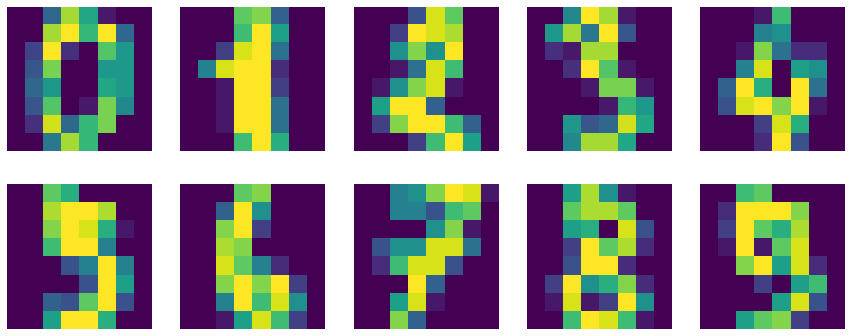

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [4]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [5]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.ran=random_state
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        '''
        print(X.shape[0])
        print(cluster_centers.shape[0])
        arr_dist=np.zeros((X.shape[0], cluster_centers.shape[0]))
        for n in range(X.shape[0]):
            for c in range(cluster_centers.shape[0]):
                arr_dist[n][c]=numpy.linalg.norm(X[n]-cluster_centers[c])
        return arr_dist
        '''
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = np.linalg.norm(X - cluster_centers[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[nearest_clusters == k, :], axis=0)
        return centroids
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
        best_sum=0
        for _ in range(self.n_init):
            np.random.RandomState(self.ran)
            random_idx = np.random.permutation(X.shape[0])
            self.centroids = X[random_idx[:self.n_clusters]]
            for i in range(self.max_iter):
                old_centroids = self.centroids
                distance = self.calculate_distances_to_centroids(X, old_centroids)
                self.labels = np.argmin(distance, axis=1)
                self.centroids = self.update_centroids(X, self.labels)
                if np.all(old_centroids == self.centroids):
                    break
            prov=X-self.centroids[self.labels]
            zal=np.array([np.linalg.norm(pr)**2 for pr in prov]).sum()
            if(best_sum==0 or zal<best_sum):
                best_sum=zal
                self.cluster_centers_=self.centroids
           
    
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>
            distance = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return np.argmin(distance, axis=1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [6]:
love=CustomKMeans(n_clusters=10)
love.fit(X)
custom_kmeans_labels = love.predict(X)
assert custom_kmeans_labels.shape == (1797,)

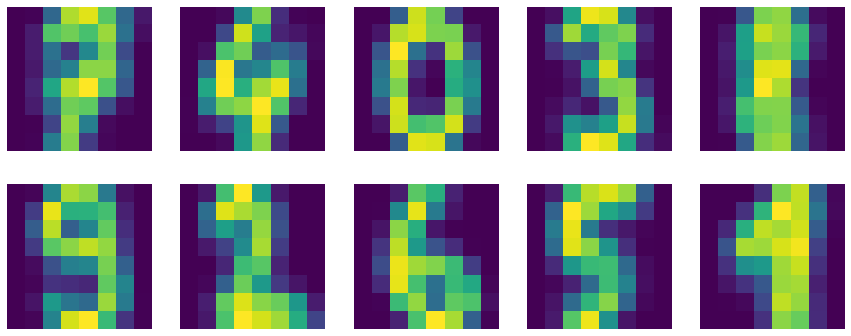

In [7]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), love.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [8]:
from sklearn.cluster import KMeans
import numpy as np

arr_n_init=[10,50,100,150,200]
arr_max_iter=[10,50,100,150,200]
value=[]
for max_iter_ in arr_max_iter:
    value_max=[]
    for  n_init_ in arr_n_init:
        kmeans = KMeans(n_clusters=10,n_init=n_init_,max_iter=max_iter_).fit(X)
        value_max.append(kmeans.inertia_)
    value.append(value_max)
for i in value:
    print(i)

[1165241.101719531, 1165251.5008269688, 1165294.4301776544, 1165213.2511790271, 1165164.9528963733]
[1165182.6410475979, 1165120.1622858848, 1165131.3862485415, 1165139.7576647112, 1165131.9497146271]
[1165449.2412335644, 1165170.9024136795, 1165146.9653637644, 1165149.694851425, 1165141.8648241463]
[1165414.691888815, 1165146.9653637644, 1165119.9814250749, 1165140.8245893973, 1165134.2177076945]
[1165171.7387219009, 1165118.704137964, 1165149.694851425, 1165131.6450797664, 1165126.1455910986]


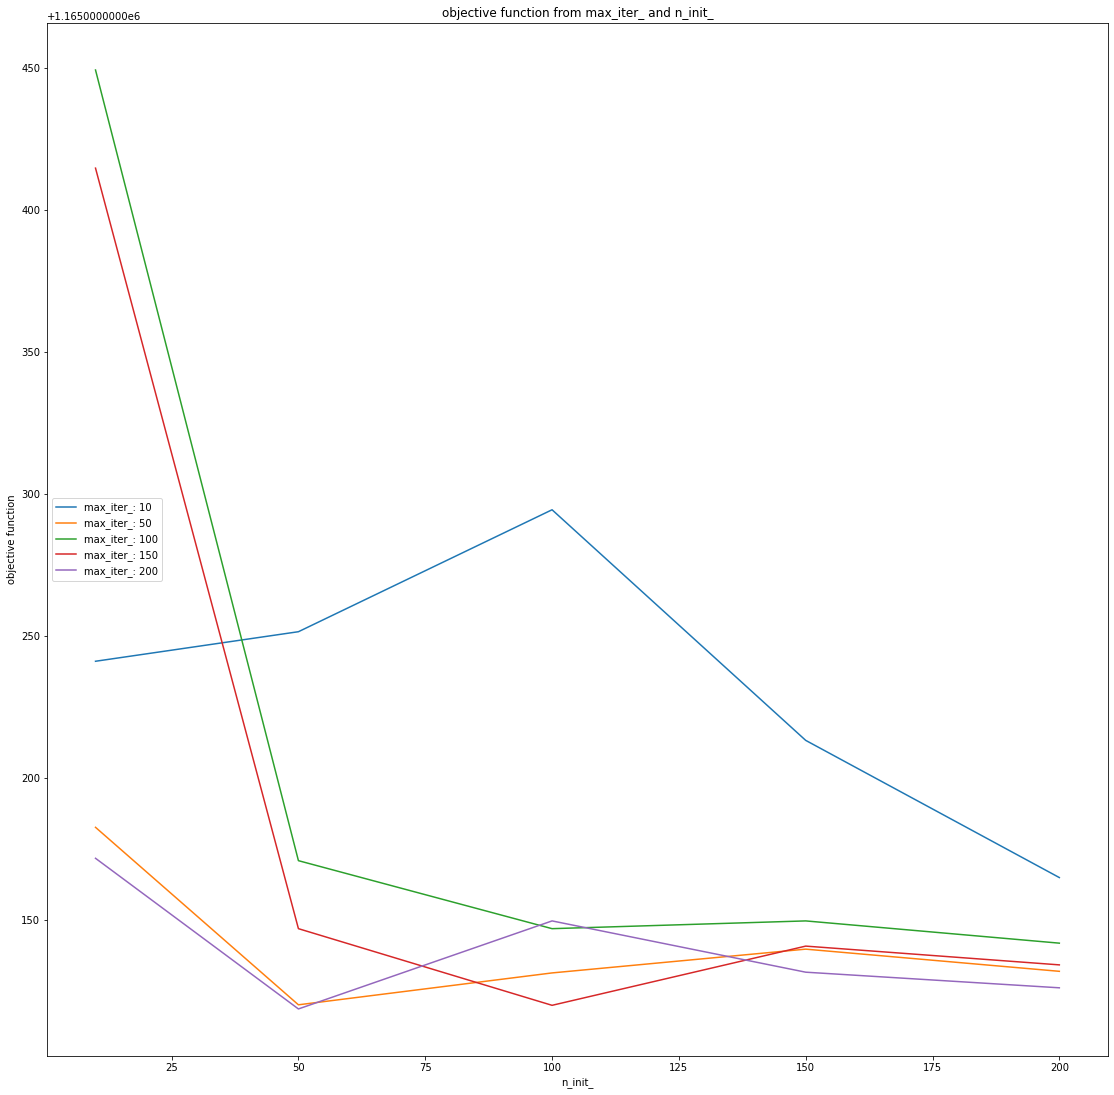

In [9]:
plt.figure(figsize=(19, 19));
for i in range(len(value)):
    plt.plot(arr_n_init, value[i], label='max_iter_: '+str(arr_max_iter[i]))
plt.title('objective function from max_iter_ and n_init_')
plt.xlabel('n_init_')
plt.ylabel('objective function')


plt.legend(loc='center left');

### Выводы
Как можем заметить глядя на график и на значения выведенные выше все значения сходятся в диапазоне  от 1165589.3094328921 до 1165116.4813265004. Видно, что эти значения почти ничем не отличаются, что говорит нам о том что решения отличаются минимально и достигаются при любом max_iter_ и n_init_ в диапазонах [10,50,100,150,200] и [10,50,100,150,200]. Это и есть оптимальные значения.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [10]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_labels = AgglomerativeClustering(n_clusters=10).fit(X).labels_
kmeans_labels = KMeans(n_clusters=10,n_init=100).fit(X).labels_

In [11]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

In [12]:
cluster_centers_KMeans=KMeans(n_clusters=10,n_init=100).fit(X).cluster_centers_

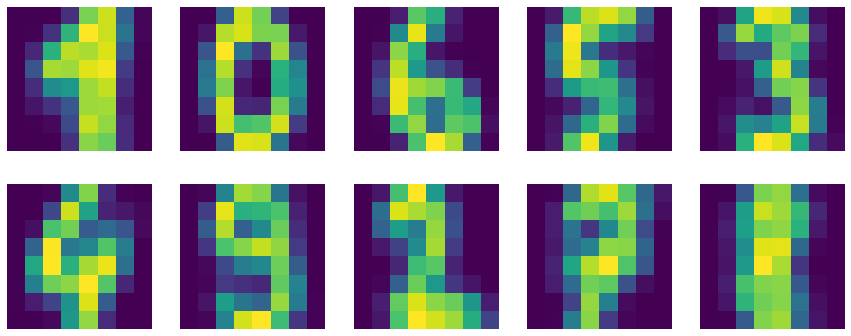

In [13]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_KMeans):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

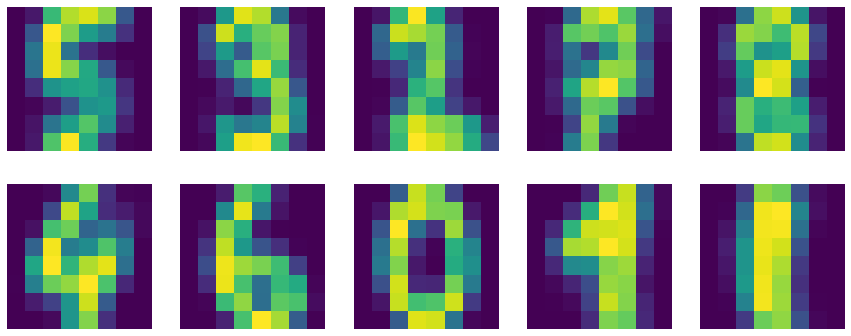

In [14]:
hierarchical_labels=AgglomerativeClustering(n_clusters=10).fit(X).labels_
hierarchical_labels
cluster_centers_AgglomerativeClustering=[]
for op in range(10):
    cluster_centers_AgglomerativeClustering.append(sum(X[np.where(hierarchical_labels == op)])/X[np.where(hierarchical_labels == op)].shape[0])
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_AgglomerativeClustering):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [15]:
from sklearn.metrics import silhouette_score

hierarchical_silhouette_score=[]
kmeans_silhouette_score=[]
for K in range(2,21):
    hierarchical_silhouette_score.append(silhouette_score(X, AgglomerativeClustering(n_clusters=K).fit(X).labels_, metric='euclidean'))
    kmeans_silhouette_score.append(silhouette_score(X, KMeans(n_clusters=K,n_init=100).fit(X).labels_, metric='euclidean'))

print(kmeans_silhouette_score)


[0.11832841100655983, 0.12649602374037858, 0.12815977245223992, 0.1379294507498871, 0.15155434865655124, 0.16351506115831504, 0.17870872376692565, 0.18899680452632878, 0.18261236402730668, 0.18323694606002777, 0.1828120477253478, 0.1856521312729902, 0.18808073738746037, 0.18702922982982265, 0.18965928008301702, 0.17721913556621335, 0.18915674501507096, 0.17723229502332513, 0.17224560882169837]


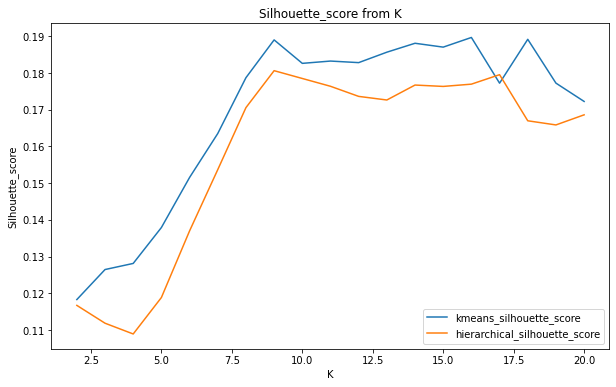

In [16]:
plt.figure(figsize=(10, 6));
plt.plot(range(2,21), kmeans_silhouette_score,label='kmeans_silhouette_score');
plt.plot(range(2,21), hierarchical_silhouette_score,label='hierarchical_silhouette_score');
plt.title('Silhouette_score from K');
plt.xlabel('K')
plt.ylabel('Silhouette_score')
plt.legend(loc='lower right');


In [17]:
print('For K=10 kmeans_silhouette_score =',kmeans_silhouette_score[8])
print('For K=10 hierarchical_silhouette_score =',hierarchical_silhouette_score[8])
hierarchical_silhouette_score_orig=hierarchical_silhouette_score[8]
kmeans_silhouette_score_orig=kmeans_silhouette_score[8]

For K=10 kmeans_silhouette_score = 0.18261236402730668
For K=10 hierarchical_silhouette_score = 0.17849659940596496


When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [18]:
from sklearn.metrics.cluster import v_measure_score

hierarchical_v_measure_score=[]
kmeans_v_measure_score=[]
for K in range(2,21):
    hierarchical_v_measure_score.append(v_measure_score(y, AgglomerativeClustering(n_clusters=K).fit(X).labels_))
    kmeans_v_measure_score.append(v_measure_score(y, KMeans(n_clusters=K,n_init=100).fit(X).labels_))

print(kmeans_v_measure_score)

[0.36001205373704537, 0.4044431773964352, 0.4550288057298879, 0.5797448900310181, 0.5964582840291015, 0.6560427074898516, 0.7186916521349556, 0.722133286564625, 0.7455546074454811, 0.7748459097648029, 0.7702165448026183, 0.7761746069875869, 0.7819302215371172, 0.7773646606303362, 0.785470119562875, 0.7932189882964562, 0.7806757110813402, 0.7722723666612469, 0.7882554851095999]


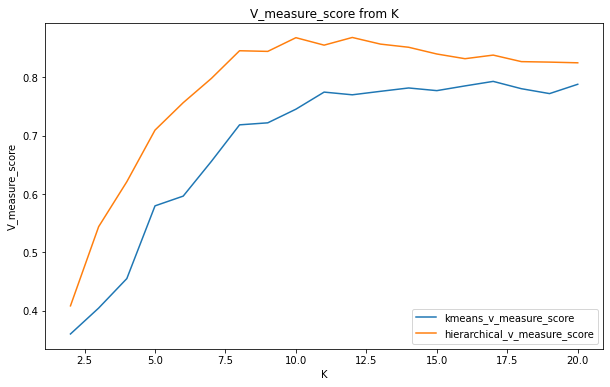

In [19]:
plt.figure(figsize=(10, 6));
plt.plot(range(2,21), kmeans_v_measure_score,label='kmeans_v_measure_score');
plt.plot(range(2,21), hierarchical_v_measure_score,label='hierarchical_v_measure_score');
plt.title('V_measure_score from K');
plt.xlabel('K')
plt.ylabel('V_measure_score')
plt.legend(loc='lower right');

In [20]:
print('For K=10 kmeans_v_measure_score =',kmeans_v_measure_score[8])
print('For K=10 hierarchical_v_measure_score =',hierarchical_v_measure_score[8])
kmeans_v_measure_score_orig=kmeans_v_measure_score[8]
hierarchical_v_measure_score_orig=hierarchical_v_measure_score[8]

For K=10 kmeans_v_measure_score = 0.7455546074454811
For K=10 hierarchical_v_measure_score = 0.8681701126909083


## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [21]:
from sklearn.decomposition import TruncatedSVD
hierarchical_silhouette_score=[]
kmeans_silhouette_score=[]
hierarchical_v_measure_score=[]
kmeans_v_measure_score=[]
for num_feat in [2,5,10,20]:
    svd = TruncatedSVD(n_components=num_feat, n_iter=7, random_state=42)
    new_data=svd.fit_transform(X)
    hierarchical_v_measure_score.append(v_measure_score(y,AgglomerativeClustering(n_clusters=10).fit(new_data).labels_))
    kmeans_v_measure_score.append(v_measure_score(y,KMeans(n_clusters=10,n_init=100).fit(new_data).labels_))
    hierarchical_silhouette_score.append(silhouette_score(X, AgglomerativeClustering(n_clusters=10).fit(new_data).labels_, metric='euclidean'))
    kmeans_silhouette_score.append(silhouette_score(X, KMeans(n_clusters=10,n_init=100).fit(new_data).labels_, metric='euclidean'))
print(kmeans_v_measure_score)
print(hierarchical_v_measure_score)

[0.34765702066050536, 0.6335183486988519, 0.7203550603165755, 0.7422729794392336]
[0.3337189903948925, 0.6756036446423491, 0.8259753348813222, 0.8171311050922185]


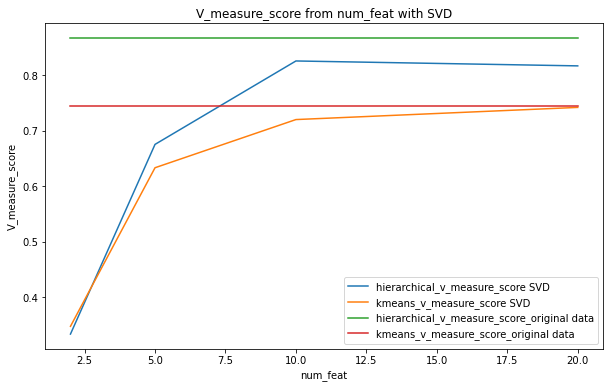

In [22]:
plt.figure(figsize=(10, 6));
plt.plot([2,5,10,20], hierarchical_v_measure_score,label='hierarchical_v_measure_score SVD');
plt.plot([2,5,10,20], kmeans_v_measure_score,label='kmeans_v_measure_score SVD');
plt.plot([2,5,10,20], [hierarchical_v_measure_score_orig,hierarchical_v_measure_score_orig,hierarchical_v_measure_score_orig,hierarchical_v_measure_score_orig],label='hierarchical_v_measure_score_original data');
plt.plot([2,5,10,20], [kmeans_v_measure_score_orig,kmeans_v_measure_score_orig,kmeans_v_measure_score_orig,kmeans_v_measure_score_orig],label='kmeans_v_measure_score_original data');
plt.title('V_measure_score from num_feat with SVD');
plt.xlabel('num_feat')
plt.ylabel('V_measure_score')
plt.legend(loc='lower right');

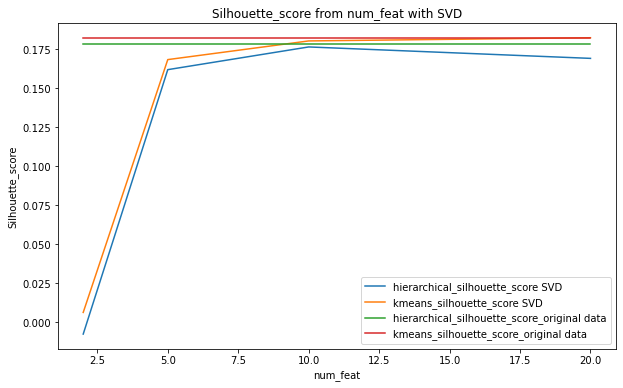

In [23]:
plt.figure(figsize=(10, 6));
plt.plot([2,5,10,20], hierarchical_silhouette_score,label='hierarchical_silhouette_score SVD');
plt.plot([2,5,10,20], kmeans_silhouette_score,label='kmeans_silhouette_score SVD');
plt.plot([2,5,10,20], [hierarchical_silhouette_score_orig,hierarchical_silhouette_score_orig,hierarchical_silhouette_score_orig,hierarchical_silhouette_score_orig],label='hierarchical_silhouette_score_original data');
plt.plot([2,5,10,20], [kmeans_silhouette_score_orig,kmeans_silhouette_score_orig,kmeans_silhouette_score_orig,kmeans_silhouette_score_orig],label='kmeans_silhouette_score_original data');

plt.title('Silhouette_score from num_feat with SVD');
plt.xlabel('num_feat')
plt.ylabel('Silhouette_score')
plt.legend(loc='lower right');

### Выводы
Как можно увидеть на графиках V_measure_score hierarchical_silhouette_score SVD не дал прироста по отношению к обычным данным, а на kmeans_silhouette_score при количестве признаков равным 20 наблюдаются идентичные результаты, но прироста так и не удалось обрести.

Silhouette_score при количестве фич равным 10 показывается идентичным как на hierarchical_silhouette_score SVD и оригинальных данных, так и на kmeans_silhouette_score SVD и оригинальных данных, но вот значительного прироста не получилось приобрести.

Но жэто и не плохо, так как это показывает что уменьшение размерности равнозначно вычислениям на оригинальных данных. Но из-за умеьшения размерности у нас уменьшается время расчётов.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

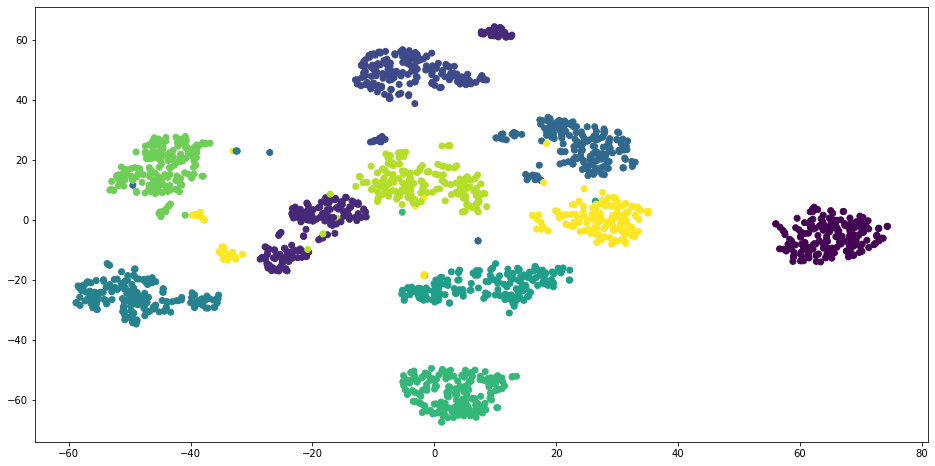

In [24]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2,random_state=42).fit_transform(X)
plt.figure(figsize=(16,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=y);

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [25]:
hierarchical_silhouette_score=[]
kmeans_silhouette_score=[]
hierarchical_v_measure_score=[]
kmeans_v_measure_score=[]
hierarchical_v_measure_score.append(v_measure_score(y,AgglomerativeClustering(n_clusters=10).fit(X_embedded).labels_))
kmeans_v_measure_score.append(v_measure_score(y,KMeans(n_clusters=10,n_init=100).fit(X_embedded).labels_))
hierarchical_silhouette_score.append(silhouette_score(X, AgglomerativeClustering(n_clusters=10).fit(X_embedded).labels_, metric='euclidean'))
kmeans_silhouette_score.append(silhouette_score(X, KMeans(n_clusters=10,n_init=100).fit(X_embedded).labels_, metric='euclidean'))
print('kmeans_v_measure_score TSNE',kmeans_v_measure_score)
print('kmeans_v_measure_score',kmeans_v_measure_score_orig)
print('hierarchical_v_measure_score TSNE',hierarchical_v_measure_score)
print('hierarchical_v_measure_score',hierarchical_v_measure_score_orig)
print('hierarchical_silhouette_score TSNE',hierarchical_silhouette_score)
print('hierarchical_silhouette_score',hierarchical_silhouette_score_orig)
print('kmeans_silhouette_score TSNE',kmeans_silhouette_score)
print('kmeans_silhouette_score',kmeans_silhouette_score_orig)

kmeans_v_measure_score TSNE [0.9137798316714038]
kmeans_v_measure_score 0.7455546074454811
hierarchical_v_measure_score TSNE [0.9111471953871231]
hierarchical_v_measure_score 0.8681701126909083
hierarchical_silhouette_score TSNE [0.1641788047760139]
hierarchical_silhouette_score 0.17849659940596496
kmeans_silhouette_score TSNE [0.16347034069873623]
kmeans_silhouette_score 0.18261236402730668


### Выводы
Как можно заметить значения силуэта не выросли но и не сильно упали, что явялется отличным результатом.

Но вот значение V_measure_score заментно возросли как на hierarchical так и на  kmeans, что является отличным результатом, так как мы мало того, что уменьшили размерность и скорили вычисления, так и получили более лучший результат по сравнению с оригинальными данными.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

Было выбрано для отображения KMeans с TSNE так как там лучший 𝑉 -score

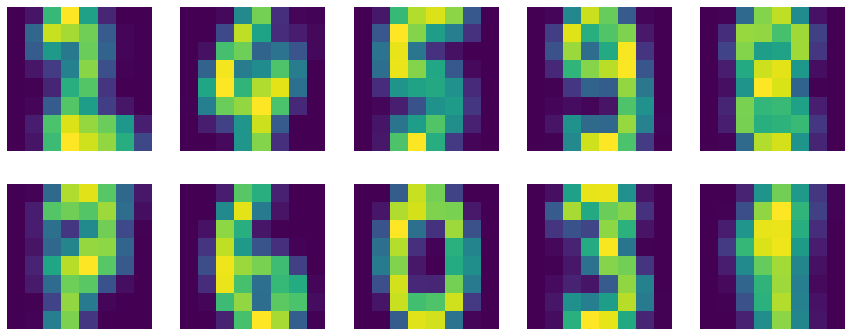

In [26]:
labels=KMeans(n_clusters=10,n_init=100).fit(X_embedded).labels_
labels
cluster_centers_=[]
for op in range(10):
    cluster_centers_.append(sum(X[np.where(labels == op)])/X[np.where(labels == op)].shape[0])
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

### Выводы
Как можно заметить центры кластеров более четкие чем  в начале на исходных данных, и можно теперь четко определить (даже по числам которые были спорные), какая цифра принадлежит к какому классу.

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

##### Ответ
Данные алгоритмы хоть и делают одно дело, но значительно отличаются и выдают аюсолютно разные ответы.
Приемущества 𝐾 - means clustering:
* Гарантируется сходимость.
* Специализируется на кластерах разных размеров и форм.

Приемущества  hierarchical clustering:
* Легкость обращения с любыми формами подобия или расстояния.
* Следовательно, применимость к любым типам атрибутов.

Недостатки 𝐾 - means clustering:
* Значение K трудно предсказать. 
* Плохо работает с глобальным кластером.

Недостатки  hierarchical clustering:
* Иерархическая кластеризация требует вычисления и хранения матрицы расстояний n×n. Для очень больших наборов данных это может быть дорого и медленно.

Таким образом можно сказать что оба алгоритма хороши, но у них есть четкая разница и недостатки, например у 𝐾 - means clustering надо заранее предсказать количество кластеров, а у hierarchical clustering, что требует больших вычислений например для больших данных.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

#### Ответ
Это довольно творческое задание, но я бы сделал подобным образом:
На основе сформированных кластеров уже взял бы цетроиды данных кластеров, а каждому сэмплу присвоил бы ближайший кластер, на основе например эвклидова расстояния. таким образом не запуская запуская заново обучение , мы можем определить каждому новому сэмплу из новых данных свой ближайший кластер. Метрики качества взял бы например 𝑉 -score так как она сравнила точность рапределния по кластерам новых данных.

**(0.5 points)** Does dimensionality reduction improve clustering results?

#### Ответ
Не всегда уменьшение размерности данных приводит к улучшению кластеризации, но уменьшение размерности данных необходимо так как
по мере добавления дополнительных функций данные становятся очень разреженными, и анализ страдает от проклятия размерности . Кроме того, легче обрабатывать небольшие наборы данных. Но так же из-за того что при уменьшении размерности могут теряться данные такие как шумы, это может привести к улучшению результата классификации. Но так же мы модем потерять очень важные данные и результат немного упадет, но не существенно, поэтому уменьшение размерности необходио для больших и разреженных данных такие как в бонусном задании, так как там данные очень сильно разреженные и алгоритмы будут выполняться очень долго.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

#### Ответ
Можно предложить несколько методов вычисления качества уменьшения размерности, например такие как:
* Матрица совместного ранжирования, которая включает в себя все ошибки ранжирования (т.е. различия между ранжированием расстояний от каждой точки до всех остальных, сравнивая низкоразмерное представление и несоответствие исходным данным)
* Метакритерий локальной непрерывности (LCMC) представляет собой безпараметрическую и широко распространенную меру качества для уменьшения размерности наборов данных. Его можно определить как среднее количество перекрытий между k-ближайшими соседями в многомерном пространстве и низкоразмерной проекцией.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

Загрузим данные и выведем первые 25 цифр.

In [27]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

Так как на всем наборе сэмплов алгоритмы иерархической кластеризации считают очень долго и компьютер уходит на взлет, то решил ограничится не всем набором данных.

In [28]:
X=X.to_numpy()[:20000]
y=y.to_numpy()[:20000]
print(X.shape)

(20000, 784)


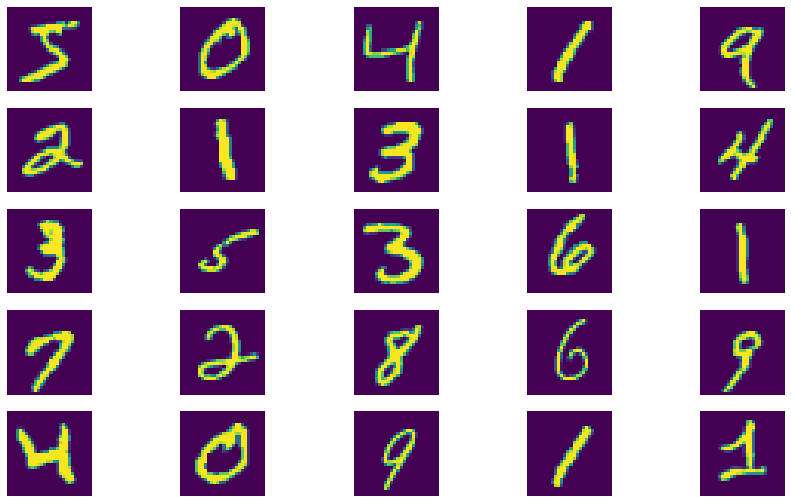

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
_, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 9))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))

##### Применим KMeans и выведем silhouette and the  𝑉 -score, а так же центроиды кластеров

In [30]:
KMeans_=KMeans(n_clusters=10,n_init=20).fit(X)
cluster_centers_KMeans=KMeans_.cluster_centers_
print('Silhouette_score:',silhouette_score(X, KMeans_.labels_, metric='euclidean'))
print('V_measure_score:',v_measure_score(y,KMeans_.labels_))

Silhouette_score: 0.057770357598822215
V_measure_score: 0.4779004842319813


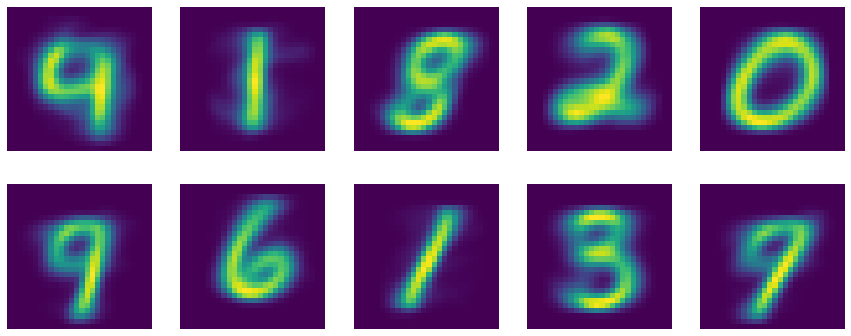

In [31]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_KMeans):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))

##### Применим AgglomerativeClustering и выведем silhouette and the  𝑉 -score, а так же центроиды кластеров

In [32]:

AgglomerativeClustering_=AgglomerativeClustering(n_clusters=10).fit(X)
cluster_centers_AgglomerativeClustering=[]
for op in range(10):
    cluster_centers_AgglomerativeClustering.append(sum(X[np.where(AgglomerativeClustering_.labels_ == op)])/X[np.where(AgglomerativeClustering_.labels_ == op)].shape[0])
print('Silhouette_score:',silhouette_score(X, AgglomerativeClustering_.labels_, metric='euclidean'))
print('V_measure_score:',v_measure_score(y,AgglomerativeClustering_.labels_))


Silhouette_score: 0.020213077112171785
V_measure_score: 0.6358561464617265


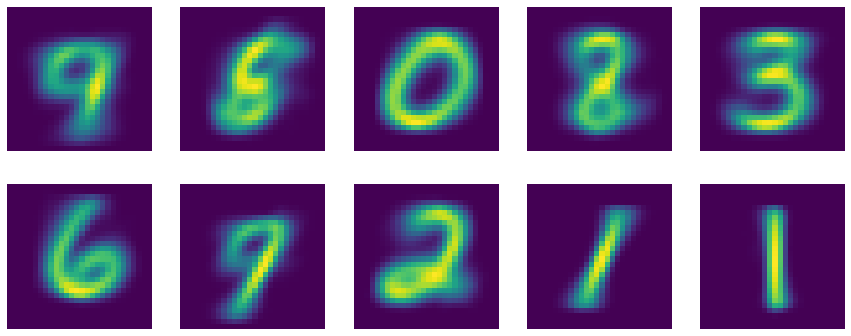

In [33]:

_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_AgglomerativeClustering):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))


##### Применим KMeans применив к ним SVD и выведем silhouette and the  𝑉 -score, а так же центроиды кластеров

Возьмем n_components=50

In [34]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
new_data=svd.fit_transform(X)

In [35]:
KMeans_=KMeans(n_clusters=10,n_init=20).fit(new_data)
cluster_centers_KMeans_SVD=[]
for op in range(10):
    cluster_centers_KMeans_SVD.append(sum(X[np.where(KMeans_.labels_ == op)])/X[np.where(KMeans_.labels_ == op)].shape[0])
print('Silhouette_score + SVD:',silhouette_score(X, KMeans_.labels_, metric='euclidean'))
print('V_measure_score + SVD:',v_measure_score(y,KMeans_.labels_))

Silhouette_score + SVD: 0.05799745239043493
V_measure_score + SVD: 0.47527126265210395


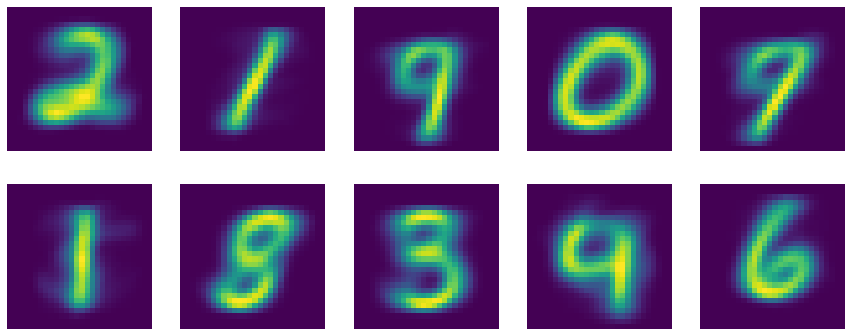

In [36]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_KMeans_SVD):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))

#### Применим AgglomerativeClustering применив к ним SVD и выведем silhouette and the 𝑉 -score, а так же центроиды кластеров

Возьмем n_components=2

In [37]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
new_data=svd.fit_transform(X)
AgglomerativeClustering_=AgglomerativeClustering(n_clusters=10).fit(new_data)
cluster_centers_AgglomerativeClustering_SVD=[]
for op in range(10):
    cluster_centers_AgglomerativeClustering_SVD.append(sum(X[np.where(AgglomerativeClustering_.labels_ == op)])/X[np.where(AgglomerativeClustering_.labels_ == op)].shape[0])
print('Silhouette_score + SVD:',silhouette_score(X, AgglomerativeClustering_.labels_, metric='euclidean'))
print('V_measure_score + SVD:',v_measure_score(y,AgglomerativeClustering_.labels_))

Silhouette_score + SVD: -0.023211792294558335
V_measure_score + SVD: 0.1899787087791842


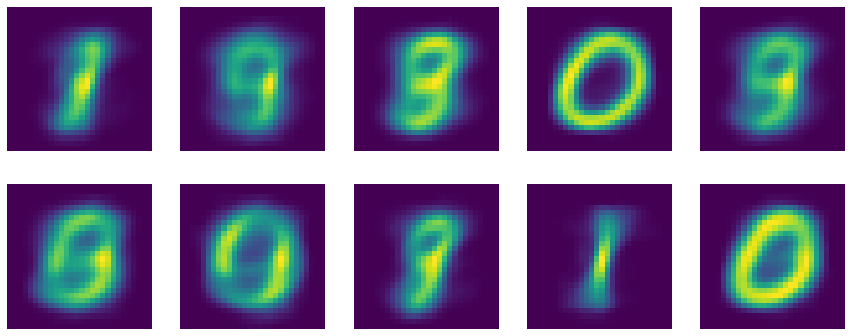

In [38]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_AgglomerativeClustering_SVD):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))

##### Применим KMeans применив к ним TSNE и выведем silhouette and the  𝑉 -score, а так же центроиды кластеров

In [39]:
X_embedded = TSNE(n_components=2,random_state=42).fit_transform(X)

In [40]:
KMeans_=KMeans(n_clusters=10,n_init=20).fit(X_embedded)
cluster_centers_KMeans_TSNE=[]
for op in range(10):
    cluster_centers_KMeans_TSNE.append(sum(X[np.where(KMeans_.labels_ == op)])/X[np.where(KMeans_.labels_ == op)].shape[0])
print('Silhouette_score + TSNE:',silhouette_score(X, KMeans_.labels_, metric='euclidean'))
print('V_measure_score + TSNE:',v_measure_score(y,KMeans_.labels_))

Silhouette_score + TSNE: 0.039662525765311214
V_measure_score + TSNE: 0.7302284587357564


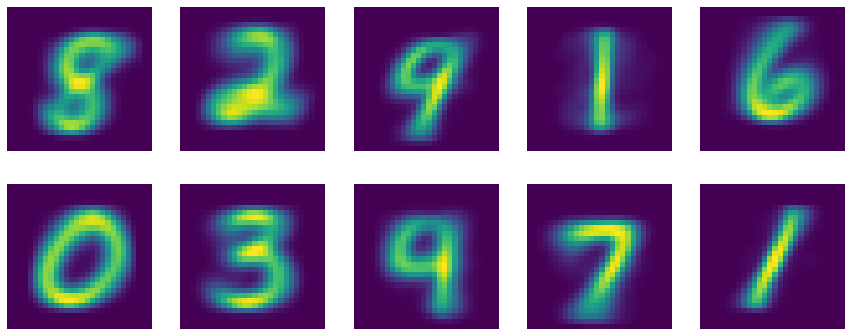

In [41]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_KMeans_TSNE):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))

#### Применим AgglomerativeClustering применив к ним TSNE и выведем silhouette and the 𝑉 -score, а так же центроиды кластеров

In [42]:
AgglomerativeClustering_=AgglomerativeClustering(n_clusters=10).fit(X_embedded)
cluster_centers_AgglomerativeClustering_TSNE=[]
for op in range(10):
    cluster_centers_AgglomerativeClustering_TSNE.append(sum(X[np.where(AgglomerativeClustering_.labels_ == op)])/X[np.where(AgglomerativeClustering_.labels_ == op)].shape[0])
print('Silhouette_score + TSNE:',silhouette_score(X, AgglomerativeClustering_.labels_, metric='euclidean'))
print('V_measure_score + TSNE:',v_measure_score(y,AgglomerativeClustering_.labels_))

Silhouette_score + TSNE: 0.031944659985999393
V_measure_score + TSNE: 0.7706701032938125


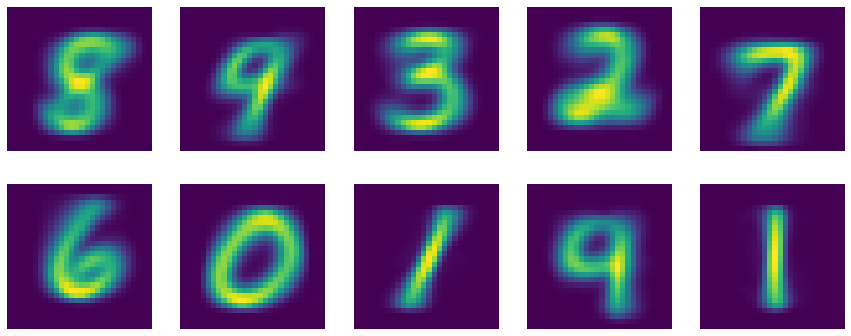

In [43]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, image in zip(axes.flatten(), cluster_centers_AgglomerativeClustering_TSNE):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))

## Выводы

Сравнив все примененные алгоритмы и все методы понижения размерности. можем вывести результаты метрых для них.


KMeans
Silhouette_score: 0.057770357598822215
V_measure_score: 0.4779004842319813

AgglomerativeClustering
Silhouette_score: 0.020213077112171785
V_measure_score: 0.6358561464617265

KMeans применив к ним SVD
Silhouette_score + SVD: 0.05799745239043493
V_measure_score + SVD: 0.47527126265210395

AgglomerativeClustering применив к ним SVD
Silhouette_score + SVD: -0.023211792294558335
V_measure_score + SVD: 0.1899787087791842

KMeans применив к ним TSNE
Silhouette_score + TSNE: 0.039662525765311214
V_measure_score + TSNE: 0.7302284587357564

AgglomerativeClustering применив к ним TSNE
Silhouette_score + TSNE: 0.031944659985999393
V_measure_score + TSNE: 0.7706701032938125

Как мы видим, самые лучшие результаты показала модель AgglomerativeClustering с данными к которым применили TSNE.